# 

In [6]:
library(tidyverse)
library(repr)
library(tidymodels)
library(recipes)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.8     ✔ rsample      1.3.0
✔ dials        1.4.0     ✔ tune         1.3.0
✔ infer        1.0.7     ✔ workflows    1.2.0
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.3.1     ✔ yardstick    1.3.2
✔ recipes      1.2.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [28]:
PLAYERS_DATA_URL = "https://raw.githubusercontent.com/Bumblet3a/dsci-individual-project/refs/heads/main/players.csv"
SESSION_DATA_URL = "https://raw.githubusercontent.com/Bumblet3a/dsci-individual-project/refs/heads/main/sessions.csv"

download.file(PLAYERS_DATA_URL, "players.csv")
download.file(SESSION_DATA_URL, "sessions.csv")

players <- read_csv("players.csv")
head(players)
sessions_data <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
player_sessions <- merge(sessions, players, all = TRUE)|>
select(Age, experience, subscribe, played_hours)|>
drop_na(Age:played_hours)
player_sessions

Age,experience,subscribe,played_hours
<dbl>,<chr>,<lgl>,<dbl>
20,Regular,TRUE,1.5
20,Regular,TRUE,1.5
17,Veteran,TRUE,0.0
⋮,⋮,⋮,⋮
23,Amateur,TRUE,56.1
17,Amateur,TRUE,0.1
20,Beginner,TRUE,1.1


In [12]:
players_scaled <- player_sessions|>
mutate(Age = scale(Age, center = TRUE),
       played_hours = scale(played_hours, center = TRUE))
players_scaled

Age,experience,subscribe,played_hours
"<dbl[,1]>",<chr>,<lgl>,"<dbl[,1]>"
0.1270154,Regular,TRUE,-1.122151
0.1270154,Regular,TRUE,-1.122151
-0.5043878,Veteran,TRUE,-1.140283
⋮,⋮,⋮,⋮
0.7584187,Amateur,TRUE,-0.4621379
-0.5043878,Amateur,TRUE,-1.1390740
0.1270154,Beginner,TRUE,-1.1269858


In [13]:

players_split <- initial_split(players_scaled, prop = 0.75, strata = subscribe)
players_testing <- testing(players_split)
players_training <- training(players_split)

In [26]:



players_model <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors = tune()
) |>
  set_engine("kknn") |>
  set_mode("regression")


play_recipe <- recipe(played_hours ~ ., data = players_training) |>
  step_scale(Age) |>
  step_center(Age)


play_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)


play_workflow <- workflow() |>
  add_recipe(play_recipe) |>
  add_model(players_model)


gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 10))


play_results <- tune_grid(
  play_workflow,
  resamples = play_vfold,
  grid = gridvals
) |>
  collect_metrics()

play_results


→ A | error:   Failed to compute `rmse()`.
               Caused by error:
               ! `truth` should be a numeric vector, not a numeric matrix.

There were issues with some computations   A: x1

There were issues with some computations   A: x5

There were issues with some computations   A: x5



Warning message:
"All models failed. Run `show_notes(.Last.tune.result)` for more information."


ERROR: [1m[33mError[39m in `estimate_tune_results()`:[22m
[33m![39m All models failed. Run `show_notes(.Last.tune.result)` for more information.


In [16]:
play_min <- play_results|>
filter(.metric == "rmse")|>
slice_min(mean, n = 1)
play_min

ERROR: Error: object 'play_results' not found


In [8]:
players_pred_accuracy <- players_prediction|>
metrics(truth = subscribe, estimate = .pred_class)
players_pred_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,35.5625
rsq,standard,0.8346
mae,standard,20.2480


In [12]:
players_mat <- players_prediction|>
conf_mat(truth = subscribe, estimate = .pred_class)
players_mat

          Truth
Prediction FALSE TRUE
     FALSE     2    0
     TRUE     11   36

In [26]:
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)


players_resample <- workflow()|>
add_recipe(players_recipe)|>
add_model(players_model)|>
fit_resamples(resamples = players_vfold)|>
collect_metrics()
players_resample

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7301970,5,0.02929188,Preprocessor1_Model1
roc_auc,binary,0.6044952,5,0.06408316,Preprocessor1_Model1


In [34]:
players_tune <-  nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
set_engine("kknn")|>
set_mode("regression")

play_fit <- workflow()|>
add_recipe(play_recipe)|>
add_model(play_spec)|>
fit(data = play_sessions_training)

players_tune_results <- workflow()|>
add_recipe(players_recipe)|>
add_model(players_tune)|>
tune_grid(resamples = players_vfold, grid = players_grid)|>
collect_metrics()
players_tune_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6055008,5,0.04521082,Preprocessor1_Model01
1,roc_auc,binary,0.5507035,5,0.04927219,Preprocessor1_Model01
2,accuracy,binary,0.6192939,5,0.04031851,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.6117308,5,0.07812870,Preprocessor1_Model09
10,accuracy,binary,0.7235140,5,0.02129237,Preprocessor1_Model10
10,roc_auc,binary,0.5866844,5,0.07853797,Preprocessor1_Model10


In [32]:
sessions <- sessions_data |>
    separate(start_time, into = c("Date", "Time"), sep = " ") |>
    separate(Date, into = c("Day", "Month", "Year"), sep = "/") |>
    separate(end_time, into = c("EDate", "ETime"), sep = " ") |>
    separate(EDate, into = c("EDay", "EMonth", "EYear"), sep = "/") |>
    mutate(Day = as.numeric(Day), EDay = as.numeric(EDay),
           Month = as.numeric(Month), EMonth = as.numeric(EMonth), 
           Year = as.numeric(Year), EYear = as.numeric(EYear)) |>
    separate(Time, into = c("Hour", "Minute"), sep = ":") |>
    separate(ETime, into = c("EHour", "EMinute"), sep = ":") |>
    mutate(Hour = as.numeric(Hour), EHour = as.numeric(EHour),
           Minute = as.numeric(Minute), EMinute = as.numeric(EMinute)) |>

    #Filter out rows that contain sessions that lasted more than a day(these data points are probably outliers)

    filter(Day==EDay & Month==EMonth & Year==EYear)



sessions

hashedEmail,Day,Month,Year,Hour,Minute,EDay,EMonth,EYear,EHour,EMinute,original_start_time,original_end_time
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30,6,2024,18,12,30,6,2024,18,24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17,6,2024,23,33,17,6,2024,23,46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25,7,2024,17,34,25,7,2024,17,57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28,7,2024,15,36,28,7,2024,15,57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25,7,2024,6,15,25,7,2024,6,22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20,5,2024,2,26,20,5,2024,2,45,1.71617e+12,1.71617e+12


average_time,median_time,sd_time
<dbl>,<dbl>,<dbl>
46.85982,26,51.73255


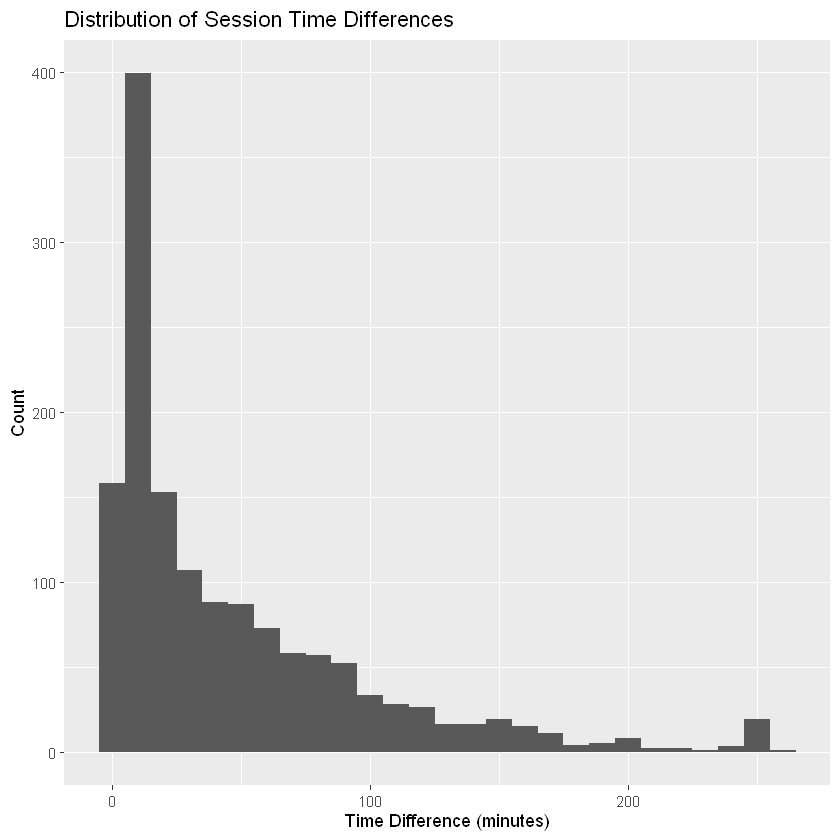

In [38]:
sessions_time_diff <- sessions |>
    mutate(time_diff = (EHour - Hour) * 60 + (EMinute - Minute))


time_stats <- sessions_time_diff |>
    summarize(average_time = mean(time_diff, na.rm = TRUE),
              median_time = median(time_diff, na.rm = TRUE),
              sd_time = sd(time_diff, na.rm = TRUE))


sessions_visualization <- sessions_time_diff |>
    ggplot(aes(x = time_diff)) +
    geom_histogram(binwidth = 10) +
    labs(title = "Distribution of Session Time Differences",
         x = "Time Difference (minutes)",
         y = "Count")

sessions_visualization
time_stats

# Skewed right distribution where most people had sessions that lasted less than 60 minutes

## Sessions Data Analysis

# Distribution Plot:
To create a distribution plot that visualizes the time differences in players' sessions, a new data frame was created with a column that calculates the time length of sessions by finding the difference between the start and ending hours, multiplying by 60, and adding the difference between the start and ending minutes. By using this column as the x-axis of a historgram with counts on the y-axis, the distribution of the length of player time sessions can be seen. The histogram depicts a skewed right distribution that has a mean play time of around 46 minutes, median time of 26 minutes, and standard deviation of 51 minutes. This large difference between the mean and median values of session time indicates that a majority of session times lie under 30 minutes, while large outlier session times are influencing the mean by increasing the overall average for the session times.